In [1]:
from clipppy import load_config
from matplotlib import pyplot as plt
import torch, pyro, numpy as np 
import collections, os
import corner
from ruamel.yaml import YAML


import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *
from channels import split_channels

VERSION_NAME = 'testing'
# cmc = 0, sigma = 0.1

STORE_DIR = 'training_data_lens_source'
STORE_DIR_VERSION = os.path.join(STORE_DIR, VERSION_NAME)
os.makedirs(STORE_DIR, exist_ok = True)
os.makedirs(STORE_DIR_VERSION, exist_ok = True)

PARAMS = YAML().load(open('params.yaml'))['lens_source']

config = load_config('config_gen_mock_lens_source.yaml')
model = config.umodel
guide = config.guide

obs = config.conditioning['image']

guide.setup()



guide.train() 
# losses += config.fit(lr=1e-2, n_steps=1000)
losses = config.fit(n_steps = 10)
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [2]:
losses

[837770510.648672,
 747509320.0358449,
 586619919.8702096,
 231862335.7182485,
 300725048.4791583,
 386845632.0928384,
 611186366.6661458,
 398277928.01027966,
 194745236.38600957,
 860559049.172906]

In [10]:
optimizer.step

<bound method PyroLRScheduler.step of <pyro.optim.lr_scheduler.PyroLRScheduler object at 0x152a5c0d9310>>

In [11]:
losses = losses - losses.min()

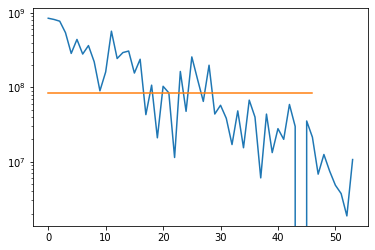

In [12]:
N = 100
rmean = np.convolve(losses, np.ones(N)/N, mode='valid')
plt.plot(losses)
plt.plot(rmean)
plt.yscale('log')

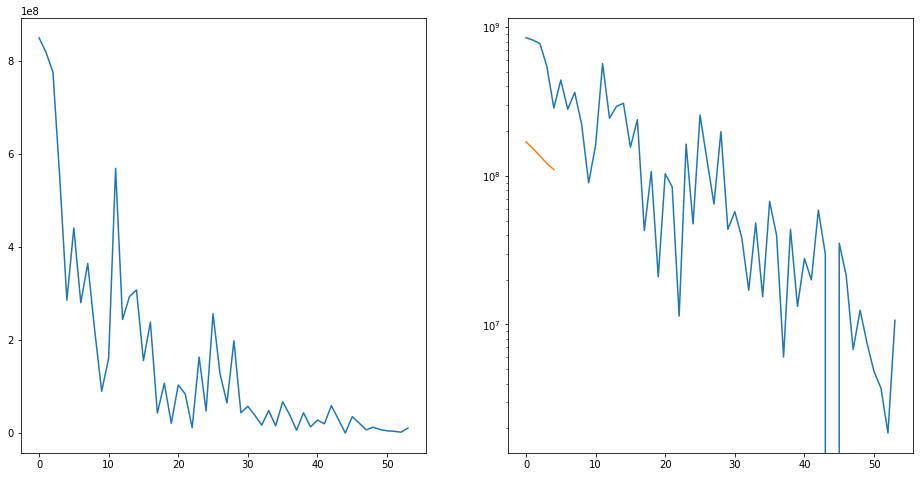

In [13]:
plot_log(losses, N = 50)

In [14]:
def plot_guide(nsamples = 1000):
    
    params = PARAMS['truth']
    
    
    with pyro.plate('plate', nsamples):
        ppd = config.guide()
    
    ppd = {key: val for key, val in ppd.items()}
    names = [k for k in ppd.keys()]
    truths = [params.get(k, None) for k in ppd.keys()]
    labels = [f'{name}={truth:.2f}' for name, truth in zip(names, truths)]
    
    print(f'{"parameter":<15} {"truth":<8} {"mean":17} {"diff"}')
    for (k, v), truth in zip(ppd.items(), truths): 
        sigma = f'({truth}{v.mean()-truth:+f}: {abs((truth - v.mean()) / v.std()):.1f}-sigma)'
        print(f'{k:<15} {truth:<7} {v.mean():+.5f} ± {v.std():.5f} {truth - v.mean():+.5f}')
    


    return corner.corner( np.stack([v.detach().numpy() for v in ppd.values()], -1), 
                         truths = truths, labels = labels);

In [15]:
def plot_fit_resids(nsamples = 1000):
    pred = torch.stack([config.ppd()['model_trace'].nodes['mu']['value'] for i in range(nsamples)], 0).mean(0)
        
#     obs = config.conditioning['image']
        
    if n_channels >= 2:
        obss  = split_channels(obs)
        preds = split_channels(pred)
        diffs = (obss - preds)
        plots = torch.cat((obss, preds, diffs))
        titles = ['truth c_1', 'truth c_2', 'truth total', 'pred c_1', 'pred c_2', 'pred total', 'diff c_1', 'diff c_2', 'diff total']
        return plot_imshow(plots = plots, nrows = 3, colorbar = True, titles = titles)
    
    else:
        plots = [obs, pred, obs - pred]
        titles = ['truth', 'mu pred', 'diff truth and mu pred', 'truth', 'mode pred', 'diff truth and mode pred', 'truth', 'mean pred', 'diff truth and mean pred', 'mode pred', 'mean pred', 'diff mode pred and mean pred']
    
        return plot_imshow(plots = plots, colorbar = True, titles = titles)



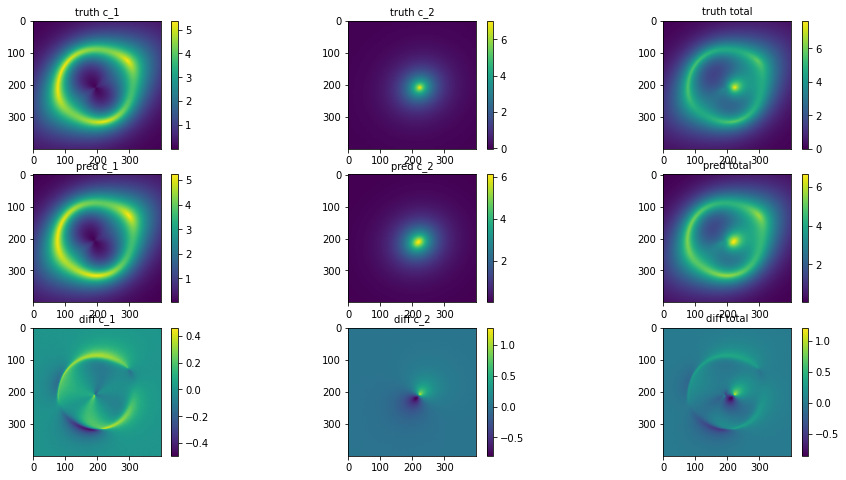

parameter       truth    mean              diff
main/x          -0.05   -0.10046 ± 0.02011 +0.05046
main/y          0.1     +0.11634 ± 0.02226 -0.01634
sersic2/x       0.3     +0.25642 ± 0.06008 +0.04358
sersic2/y       0.1     +0.15083 ± 0.05599 -0.05083


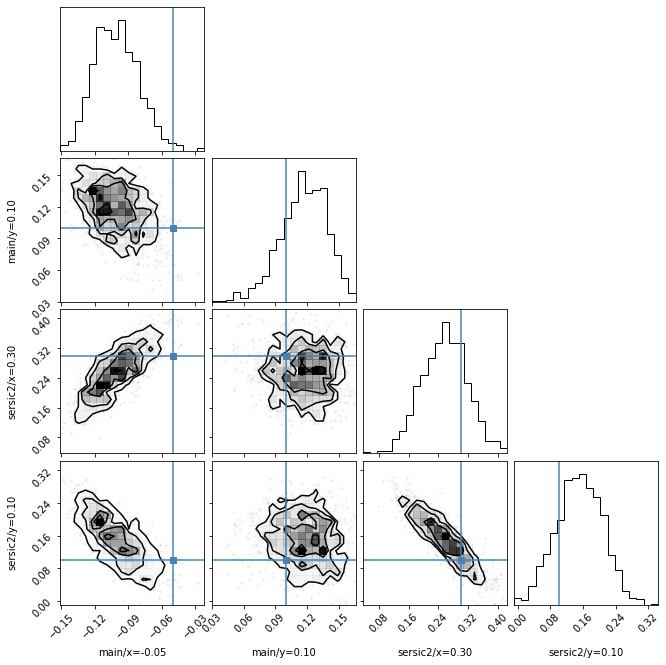

In [16]:
plot_fit_resids(nsamples = 100)

plot_guide(nsamples = 1000);